# Analyze AFM tip solvation

This notebook demonstrates deposition of an SDS adsorption layer on a non-spherical AFM tip model.

## Initialization

### IPython magic

In [239]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



### Imports

In [240]:
import ase.io # here used for reading pdb files
from ase.visualize import view
from ase.visualize.plot import plot_atoms # has nasty offset issues
from cycler import cycler # here used for cycling through colors in plots
import datetime
import fabric # for pythonic ssh connections
from fireworks import LaunchPad, Firework, Tracker, Workflow 
from fireworks import FileTransferTask, PyTask, ScriptTask

# FireWorks functionality 
from fireworks import Firework, LaunchPad, ScriptTask, Workflow
from fireworks.user_objects.firetasks.templatewriter_task import TemplateWriterTask
from fireworks.user_objects.firetasks.filepad_tasks import AddFilesTask, GetFilesTask, GetFilesByQueryTask
from imteksimfw.fireworks.user_objects.firetasks.cmd_tasks import CmdTask
from fireworks.utilities.filepad import FilePad # direct FilePad access, similar to the familiar LaunchPad

from collections.abc import Iterable
import glob
import gc # manually clean up memory with gc.collect()
import gromacs # GromacsWrapper, here used for evoking gmc commands, reading and writing .ndx files
# from io import StringIO, TextIOWrapper
import io
from IPython.display import display, Image #, Video # display image files within notebook
from ipywidgets import Video  # display video within notebook
import itertools # for products of iterables
import json # generic serialization of lists and dicts
import jinja2 # here used for filling packmol input script template
import jinja2.meta # for gathering variables in a jinja2 template
import logging 
import matplotlib.pyplot as plt
import MDAnalysis as mda # here used for reading and analyzing gromacs trajectories
import MDAnalysis.analysis.rdf as mda_rdf
import MDAnalysis.analysis.rms as mda_rms
from mpl_toolkits.mplot3d import Axes3D # here used for 3d point cloud scatter plot
import miniball # finds minimum bounding sphere of a point set
import nglview
import numpy as np
import os, os.path
import pandas as pd
import panedr # reads GROMACS edr into pandas df, requires pandas and pbr
import parmed as pmd # has quite a few advantages over ASE when it comes to parsing pdb
from pprint import pprint
import pymongo # for sorting in queries
import scipy.constants as sc
import subprocess # used for evoking external packmol
import sys
import tempfile
import yaml

GromacsWrapper might need a file `~/.gromacswrapper.cfg` with content
```cfg
[Gromacs]
tools = gmx gmx_d 
# gmx_mpi_d gmx_mpi_d

# name of the logfile that is written to the current directory
logfilename = gromacs.log

# loglevels (see Python's logging module for details)
#   ERROR   only fatal errors
#   WARN    only warnings
#   INFO    interesting messages
#   DEBUG   everything

# console messages written to screen
loglevel_console = INFO

# file messages written to logfilename
loglevel_file = DEBUG
```
in order to know the GROMACS executables it is allowed to use. Otherwise,
calls to `gmx_mpi` or `gmx_mpi_d` without MPI wrapper might lead to MPI 
warnings in output that cause GromacsWrapper to fail.

### Logging

In [241]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

ParmEd needs to know the GROMACS topology folder, usually get this from 
envionment variable `GMXLIB`:

### Function definitions

In [242]:
def find_undeclared_variables(infile):
    """identify all variables evaluated in a jinja 2 template file"""
    env = jinja2.Environment()
    with open(infile) as template_file:
        parsed = env.parse(template_file.read())

    undefined = jinja2.meta.find_undeclared_variables(parsed)
    return undefined

In [243]:
def memuse():
    """Quick overview on memory usage of objects in Jupyter notebook"""
    # https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    return sorted([(x, sys.getsizeof(globals().get(x))) for x in dir(sys.modules['__main__']) if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

### Global settings

In [19]:
# pandas settings
pd.options.display.max_rows = 200
pd.options.display.max_columns = 16
pd.options.display.max_colwidth = 256

In [244]:
os.environ['GMXLIB'] = '/gmx_top'

In [245]:
# pmd.gromacs.GROMACS_TOPDIR = os.environ['GMXLIB']
pmd.gromacs.GROMACS_TOPDIR = '/gmx_top'

In [246]:
# prefix = '/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol'
prefix = '/mnt/dat/work'

In [247]:
work_prefix = '/mnt/dat/work/tmp'

In [248]:
try:
    os.mkdir(work_prefix)
except FileExistsError as exc:
    print(exc)

[Errno 17] File exists: '/mnt/dat/work/tmp'


In [249]:
os.chdir(work_prefix)

In [250]:
# the FireWorks LaunchPad
lp = LaunchPad.auto_load() #Define the server and database
# FilePad behaves analogous to LaunchPad
fp = FilePad.auto_load()

## Conversion from LAMMPS data format to PDB

The following bash / tcl snippet converts a LAMMPS data file to PDB, assigning the desired names as mapped in a yaml file
```bash
#!/bin/bash
# echo "package require jlhvmd; jlh lmp2pdb indenter.lammps indenter.pdb" | vmd -eofexit
vmd -eofexit << 'EOF'
package require jlhvmd
topo readlammpsdata indenter.lammps
jlh type2name SDS_type2name.yaml
jlh name2res  SDS_name2res.yaml
set sel [atomselect top all]
$sel writepdb indenter.pdb
EOF

pdb_chain.py indenter.pdb > indenter_wo_chainid.pdb
pdb_reres_by_atom_9999.py indenter_wo_chainid.pdb > indenter_reres.pdb
```

Requires

* VMD (tested with 1.9.3) with topotools
* jlhvmd VMD plugin: https://github.com/jotelha/jlhvmd
* pdb-tools: https://github.com/haddocking/pdb-tools/

## Overview

### Overview on projects in database

In [252]:
query = {'metadata.datetime': {'$gt': '2020'} }

In [253]:
fp.filepad.count_documents(query)

9358

In [254]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 'project': '$metadata.project' },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # pull 'project' field up in hierarchy
        "$addFields": { 
            "project": "$_id.project",
        },
    },
    {  # drop nested '_id.project'
        "$project": { 
            "_id": False 
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

# sort_aggregation
#aggregation_pipeline = [ match_aggregation, group_aggregation, set_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [c for c in cursor]
res_df = pd.DataFrame(data=res) # pandas Dataframe is just nice for printing in notebook

In [255]:
res_df

,object_count,earliest,latest,project
0,121,2020-07-29 02:02:42.481188,2020-07-29 02:02:43.330143,2020-07-29-sds-on-au-111-indenter-passivation-trial
1,100,2020-07-29 02:01:24.236772,2020-07-29 02:01:24.390214,2020-07-29-ctab-on-au-111-indenter-passivation-trial
2,200,2020-07-28 14:16:45.250627,2020-07-28 18:34:03.236688,2020-07-28-passivation-trial
3,1653,2020-07-21 01:13:12.200383,2020-07-21 01:13:13.756743,2020-07-21-passivation-trial
4,278,2020-07-20 22:19:46.798328,2020-07-20 22:19:48.273066,2020-07-20-passivation-trial-d
5,316,2020-07-20 16:28:44.921863,2020-07-20 16:28:47.699103,2020-07-20-passivation-trial-c
6,278,2020-07-20 12:31:37.328725,2020-07-20 12:31:41.060445,2020-07-20-passivation-trial-b
7,278,2020-07-20 10:48:46.162767,2020-07-20 10:48:47.754857,2020-07-20-passivation-trial
8,1674,2020-07-19 22:52:59.921460,2020-07-19 22:53:01.334582,2020-07-19-passivation
9,278,2020-07-19 00:39:08.874821,2020-07-19 00:39:09.172045,2020-07-19-passivation-trial-a


### Overview on steps in project

In [256]:
project_id = '2020-07-29-sds-on-au-111-indenter-passivation-trial'

In [257]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [258]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

134

In [259]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [260]:
res_df

,step,earliest,latest,object_count
0,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:43.330022,2020-07-29 02:02:43.330143,21
1,GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:43.278043,2020-07-29 02:02:43.278176,21
2,GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:43.208588,2020-07-29 02:02:43.208709,20
3,GromacsSolvate:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:43.163875,2020-07-29 02:02:43.163883,2
4,GromacsPull:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:43.163418,2020-07-29 02:02:43.163551,23
5,GromacsPullPrep:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:43.108852,2020-07-29 02:02:43.108869,4
6,GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:43.108194,2020-07-29 02:02:43.108293,19
7,GromacsPrep:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:43.069957,2020-07-29 02:02:43.069970,3
8,SphericalSurfactantPacking:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:43.069437,2020-07-29 02:02:43.069451,2
9,PackingConstraintSpheres:ProcessAnalyzeAndVisualize:push_filepad,2020-07-29 02:02:42.907878,2020-07-29 02:02:42.907893,2


In [261]:
res_df['step'].values

array(['GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',
       ' GromacsSolvate:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsPull:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsPullPrep:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsPrep:ProcessAnalyzeAndVisualize:push_filepad',
       'SphericalSurfactantPacking:ProcessAnalyzeAndVisualize:push_filepad',
       'PackingConstraintSpheres:ProcessAnalyzeAndVisualize:push_filepad',
       'SurfactantMoleculeMeasures:ProcessAnalyzeAndVisualize:push_filepad',
       'IndenterBoundingSphere:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsPullPrep:GromacsPullPrepMain:push_infiles',
       'GromacsNVTEquilibration:GromacsNVTEquilibrationMain:push_infi

### Overview on objects in project

In [262]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [263]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

134

In [264]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'step', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [265]:
res_df

,type,step,name,earliest,latest,object_count
0,mp4_file,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330143,2020-07-29 02:02:43.330143,1
1,surfactant_tail_rmsd,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330137,2020-07-29 02:02:43.330137,1
2,surfactant_head_rmsd,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330131,2020-07-29 02:02:43.330131,1
3,substrate_rmsd,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330125,2020-07-29 02:02:43.330125,1
4,counterion_rmsd,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330119,2020-07-29 02:02:43.330119,1
5,surfactant_tail_surfactant_tail_rdf,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330112,2020-07-29 02:02:43.330112,1
6,surfactant_head_surfactant_tail_rdf,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330107,2020-07-29 02:02:43.330107,1
7,surfactant_head_surfactant_head_rdf,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330100,2020-07-29 02:02:43.330100,1
8,substrate_surfactant_tail_rdf,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330095,2020-07-29 02:02:43.330095,1
9,substrate_surfactant_head_rdf,GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad,NaN,2020-07-29 02:02:43.330089,2020-07-29 02:02:43.330089,1


### Overview on images by distinct steps

In [266]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
}

In [267]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

4

In [268]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [269]:
res_df

,step,type,name,earliest,latest,object_count
0,SphericalSurfactantPacking:ProcessAnalyzeAndVisualize:push_filepad,png_file,NaN,2020-07-29 02:02:43.069451,2020-07-29 02:02:43.069451,1
1,PackingConstraintSpheres:ProcessAnalyzeAndVisualize:push_filepad,png_file,NaN,2020-07-29 02:02:42.907893,2020-07-29 02:02:42.907893,1
2,SurfactantMoleculeMeasures:ProcessAnalyzeAndVisualize:push_filepad,png_file,NaN,2020-07-29 02:02:42.730079,2020-07-29 02:02:42.730079,1
3,IndenterBoundingSphere:ProcessAnalyzeAndVisualize:push_filepad,png_file,NaN,2020-07-29 02:02:42.481204,2020-07-29 02:02:42.481204,1


In [270]:
res_df["step"][0]

'SphericalSurfactantPacking:ProcessAnalyzeAndVisualize:push_filepad'

## Packing visualization

### Indenter bounding sphere

In [271]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'IndenterBoundingSphere'}
}

In [272]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [273]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

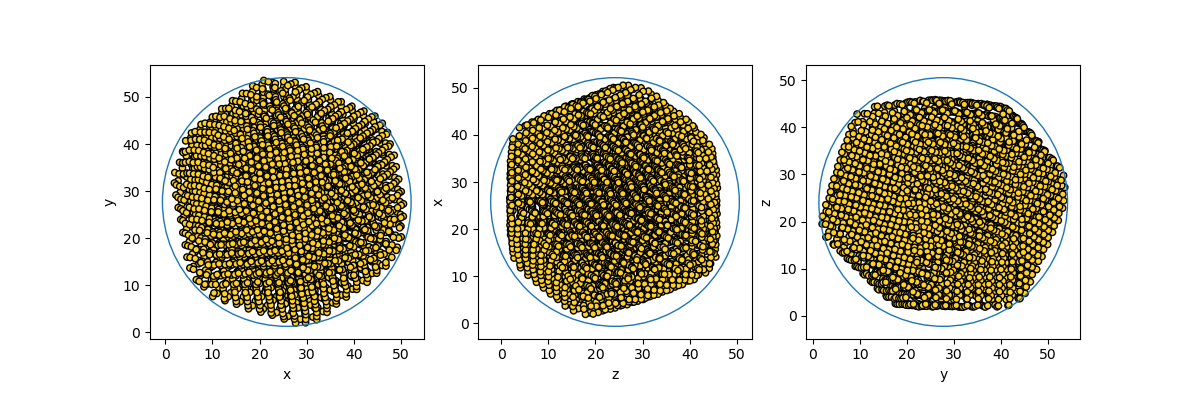

In [274]:
for obj in obj_list:
    display(obj)

### Surfactant measures

In [275]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'SurfactantMoleculeMeasures'}
}

In [276]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [277]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

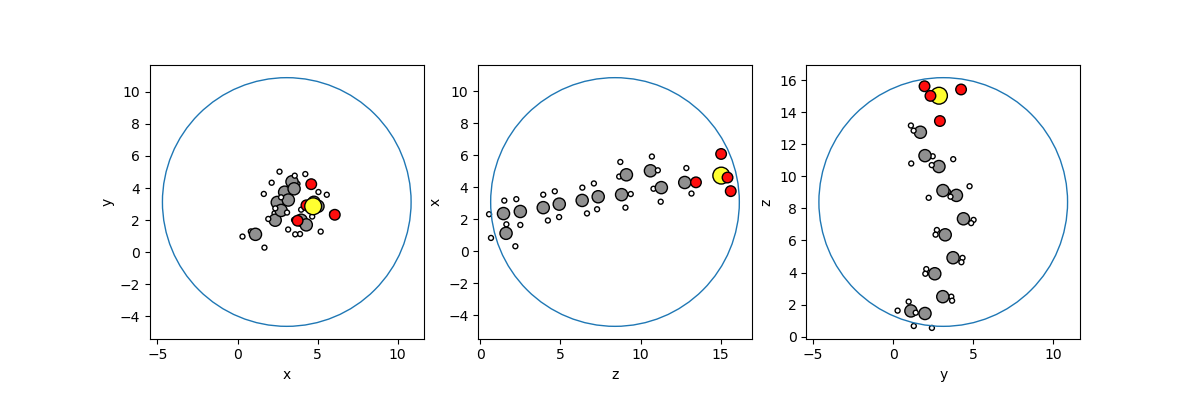

In [278]:
obj_list[0]

### Packing constraints

In [279]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'PackingConstraintSpheres'}
}

In [280]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [281]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

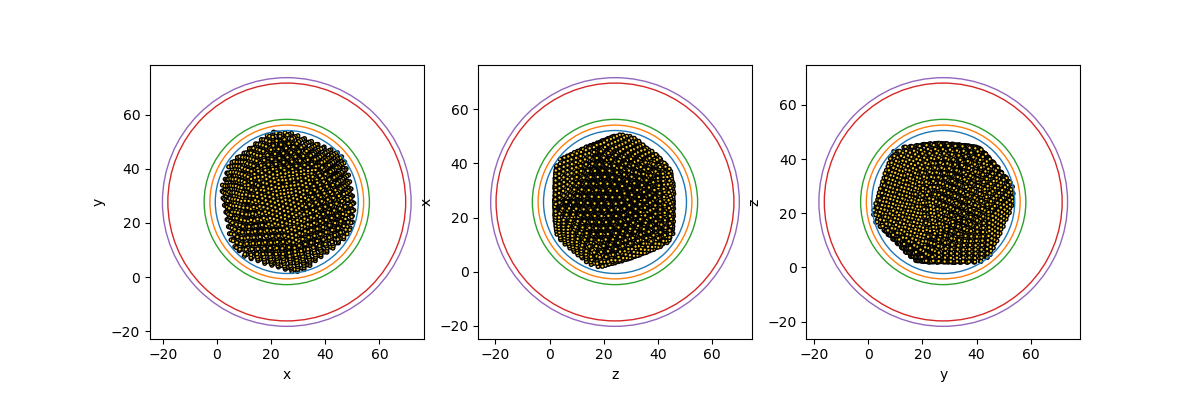

In [282]:
obj_list[0]

### Packed film

In [283]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'SphericalSurfactantPacking'}
}

In [284]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [285]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

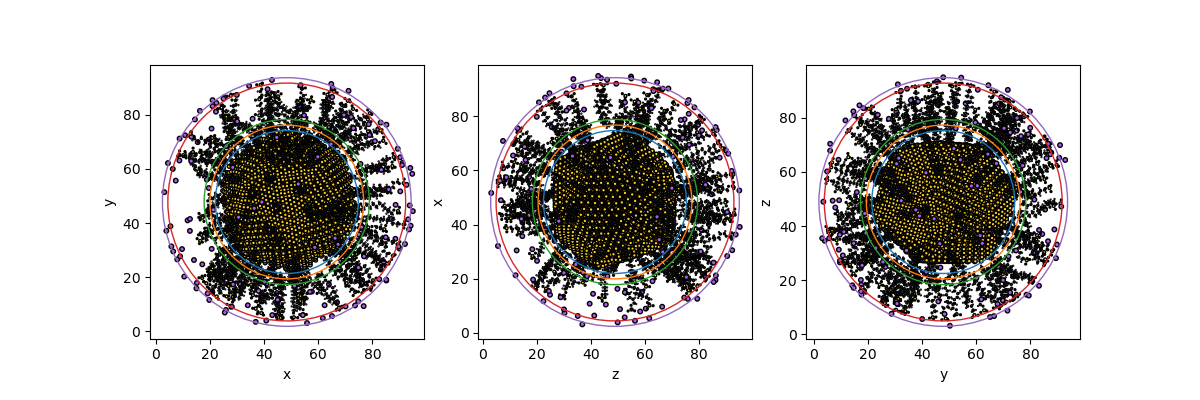

In [286]:
for obj in obj_list:
    display(obj)

## Energy minimization analysis

### Overview on objects in step

In [287]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad'
}

In [288]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

19

In [289]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [290]:
res_df

,type,name,earliest,latest,object_count
0,mp4_file,NaN,2020-07-29 02:02:43.108293,2020-07-29 02:02:43.108293,1
1,surfactant_tail_rmsd,NaN,2020-07-29 02:02:43.108287,2020-07-29 02:02:43.108287,1
2,surfactant_head_rmsd,NaN,2020-07-29 02:02:43.108281,2020-07-29 02:02:43.108281,1
3,substrate_rmsd,NaN,2020-07-29 02:02:43.108276,2020-07-29 02:02:43.108276,1
4,counterion_rmsd,NaN,2020-07-29 02:02:43.108271,2020-07-29 02:02:43.108271,1
5,surfactant_tail_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.108266,2020-07-29 02:02:43.108266,1
6,surfactant_head_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.108261,2020-07-29 02:02:43.108261,1
7,surfactant_head_surfactant_head_rdf,NaN,2020-07-29 02:02:43.108256,2020-07-29 02:02:43.108256,1
8,substrate_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.108251,2020-07-29 02:02:43.108251,1
9,substrate_surfactant_head_rdf,NaN,2020-07-29 02:02:43.108246,2020-07-29 02:02:43.108246,1


### Global observables

In [291]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',  #{'$regex': 'GromacsEnergyMinimization'}
    "metadata.type": 'energy_file',
}
fp.filepad.count_documents(query)

1

In [292]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [293]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [294]:
[ c for c in cursor]

[{'_id': {'nmolecules': 153},
  'degeneracy': 1,
  'latest': '5f20bfd07dc9cfbf44a4b8bb'}]

In [295]:
res_mi_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        em_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),em_df.index],
            names=[*c["_id"].keys(),'step'])
        em_mi_df = em_df.set_index(mi)        
        res_mi_list.append(em_mi_df)
    print('.',end='')
print('')

res_mi_df = pd.concat(res_mi_list)
res_df = res_mi_df.reset_index()

.


In [296]:
res_mi_df

Time          Bond           U-B  Proper Dih.  \
nmolecules step                                                        
153        0.0          0.0  62133.402344  36564.699219  5670.489258   
           1.0          1.0  61673.414062  36503.113281  5670.561035   
           2.0          2.0  61121.402344  36429.222656  5670.654785   
           3.0          3.0  60458.937500  36340.562500  5670.779785   
           4.0          4.0  59664.136719  36234.152344  5670.948242   
...                     ...           ...           ...          ...   
           9995.0    9995.0    233.058395  12166.970703  3986.871826   
           9996.0    9996.0    233.247940  12164.144531  3986.874023   
           9998.0    9998.0    232.224838  12165.687500  3986.873779   
           9999.0    9999.0    233.588730  12164.032227  3986.881836   
           10000.0  10000.0    232.471176  12166.282227  3986.880615   

                          LJ-14    Coulomb-14      LJ (SR)   Coulomb (SR)  \
nmolecules step                                                             
153        0.0      3515.553223  40657.925781 -586252.7500  -65941.820312   
           1.0      3509.745850  40654.890625 -586257.0000  -65945.578125   
           2.0      3502.744629  40651.230469 -586262.0000  -65950.109375   
           3.0      3494.292725  40646.812500 -586268.0625  -65955.585938   
           4.0      3484.076904  40641.484375 -586275.1875  -65962.218750   
...                         ...           ...          ...            ...   
           9995.0    921.905823  39504.113281 -583586.6875 -100950.773438   
           9996.0    921.434204  39503.667969 -583585.0625 -100949.562500   
           9998.0    921.712585  39503.890625 -583586.1875 -100950.531250   
           9999.0    921.388977  39503.472656 -583585.4375 -100950.648438   
           10000.0   921.797607  39503.796875 -583587.0000 -100951.968750   

                    ...  Pres-YX  Pres-YY  Pres-YZ  Pres-ZX  Pres-ZY  Pres-ZZ  \
nmolecules step     ...                                                         
153        0.0      ...      0.0      0.0      0.0      0.0      0.0      0.0   
           1.0      ...      0.0      0.0      0.0      0.0      0.0      0.0   
           2.0      ...      0.0      0.0      0.0      0.0      0.0      0.0   
           3.0      ...      0.0      0.0      0.0      0.0      0.0      0.0   
           4.0      ...      0.0      0.0      0.0      0.0      0.0      0.0   
...                 ...      ...      ...      ...      ...      ...      ...   
           9995.0   ...      0.0      0.0      0.0      0.0      0.0      0.0   
           9996.0   ...      0.0      0.0      0.0      0.0      0.0      0.0   
           9998.0   ...      0.0      0.0      0.0      0.0      0.0      0.0   
           9999.0   ...      0.0      0.0      0.0      0.0      0.0      0.0   
           10000.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   

                    #Surf*SurfTen  T-rest  
nmolecules step                            
153        0.0                0.0     0.0  
           1.0                0.0     0.0  
           2.0                0.0     0.0  
           3.0                0.0     0.0  
           4.0                0.0     0.0  
...                           ...     ...  
           9995.0             0.0     0.0  
           9996.0             0.0     0.0  
           9998.0             0.0     0.0  
           9999.0             0.0     0.0  
           10000.0            0.0     0.0  

[7922 rows x 31 columns]

In [297]:
res_df

,nmolecules,step,Time,Bond,U-B,Proper Dih.,LJ-14,Coulomb-14,...,Pres-YX,Pres-YY,Pres-YZ,Pres-ZX,Pres-ZY,Pres-ZZ,#Surf*SurfTen,T-rest
0,153,0.0,0.0,62133.402344,36564.699219,5670.489258,3515.553223,40657.925781,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,153,1.0,1.0,61673.414062,36503.113281,5670.561035,3509.745850,40654.890625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,153,2.0,2.0,61121.402344,36429.222656,5670.654785,3502.744629,40651.230469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,153,3.0,3.0,60458.937500,36340.562500,5670.779785,3494.292725,40646.812500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,153,4.0,4.0,59664.136719,36234.152344,5670.948242,3484.076904,40641.484375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7917,153,9995.0,9995.0,233.058395,12166.970703,3986.871826,921.905823,39504.113281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7918,153,9996.0,9996.0,233.247940,12164.144531,3986.874023,921.434204,39503.667969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7919,153,9998.0,9998.0,232.224838,12165.687500,3986.873779,921.712585,39503.890625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7920,153,9999.0,9999.0,233.588730,12164.032227,3986.881836,921.388977,39503.472656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


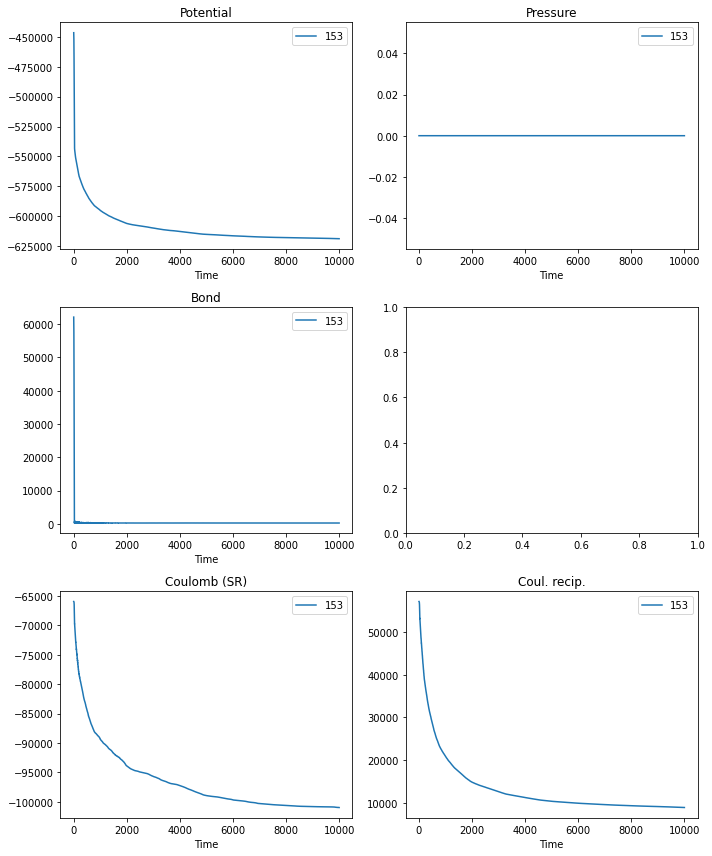

In [298]:
y_quantities = [
    'Potential',
    'Pressure',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

positions = [
    (0,0),
    (0,1),
    (1,0),
    (2,0),
    (2,1),
]
fig, ax = plt.subplots(3,2,figsize=(10,12))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

###  Visualize trajectory

In [299]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [300]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [301]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [302]:
res_df

,step,type,name,earliest,latest,object_count
0,GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad,mp4_file,NaN,2020-07-29 02:02:43.108293,2020-07-29 02:02:43.108293,1


In [303]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        obj_list.append(Video.from_file(tmp.name))
    print('.',end='')

.

In [304]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

.

In [305]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(153,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10=tmdat\x00\x00\…

## Pulling analysis

### Overview on objects in step

In [306]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsPull:ProcessAnalyzeAndVisualize:push_filepad'
}

In [307]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

23

In [308]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [309]:
res_df

,type,name,earliest,latest,object_count
0,mp4_file,NaN,2020-07-29 02:02:43.163551,2020-07-29 02:02:43.163551,1
1,surfactant_tail_rmsd,NaN,2020-07-29 02:02:43.163545,2020-07-29 02:02:43.163545,1
2,surfactant_head_rmsd,NaN,2020-07-29 02:02:43.163539,2020-07-29 02:02:43.163539,1
3,substrate_rmsd,NaN,2020-07-29 02:02:43.163534,2020-07-29 02:02:43.163534,1
4,counterion_rmsd,NaN,2020-07-29 02:02:43.163528,2020-07-29 02:02:43.163528,1
5,surfactant_tail_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.163523,2020-07-29 02:02:43.163523,1
6,surfactant_head_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.163518,2020-07-29 02:02:43.163518,1
7,surfactant_head_surfactant_head_rdf,NaN,2020-07-29 02:02:43.163512,2020-07-29 02:02:43.163512,1
8,substrate_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.163507,2020-07-29 02:02:43.163507,1
9,substrate_surfactant_head_rdf,NaN,2020-07-29 02:02:43.163502,2020-07-29 02:02:43.163502,1


### Global observables

The `gmx energy` table:

```
  1  Restraint-Pot.   2  U-B              3  Proper-Dih.      4  LJ-14         
  5  Coulomb-14       6  LJ-(SR)          7  Coulomb-(SR)     8  Coul.-recip.  
  9  Position-Rest.  10  COM-Pull-En.    11  Potential       12  Kinetic-En.   
 13  Total-Energy    14  Temperature     15  Pressure        16  Constr.-rmsd  
 17  Vir-XX          18  Vir-XY          19  Vir-XZ          20  Vir-YX        
 21  Vir-YY          22  Vir-YZ          23  Vir-ZX          24  Vir-ZY        
 25  Vir-ZZ          26  Pres-XX         27  Pres-XY         28  Pres-XZ       
 29  Pres-YX         30  Pres-YY         31  Pres-YZ         32  Pres-ZX       
 33  Pres-ZY         34  Pres-ZZ         35  #Surf*SurfTen   36  T-rest       
 ```
 converted to dict with regex
 
     \s+([0-9]+)\s+([^\s]+)
 
 and replacement
 
     '$2': $1,\n

In [310]:
gmx_energy_dict = {
    'Restraint-Pot.': 1,
    'U-B': 2,
    'Proper-Dih.': 3,
    'LJ-14': 4,
    'Coulomb-14': 5,
    'LJ-(SR)': 6,
    'Coulomb-(SR)': 7,
    'Coul.-recip.': 8,
    'Position-Rest.': 9,
    'COM-Pull-En.': 10,
    'Potential': 11,
    'Kinetic-En.': 12,
    'Total-Energy': 13,
    'Temperature': 14,
    'Pressure': 15,
    'Constr.-rmsd': 16,
    'Vir-XX': 17,
    'Vir-XY': 18,
    'Vir-XZ': 19,
    'Vir-YX': 20,
    'Vir-YY': 21,
    'Vir-YZ': 22,
    'Vir-ZX': 23,
    'Vir-ZY': 24,
    'Vir-ZZ': 25,
    'Pres-XX': 26,
    'Pres-XY': 27,
    'Pres-XZ': 28,
    'Pres-YX': 29,
    'Pres-YY': 30,
    'Pres-YZ': 31,
    'Pres-ZX': 32,
    'Pres-ZY': 33,
    'Pres-ZZ': 34,
    '#Surf*SurfTen': 35,
    'T-rest': 36,
}

In [311]:
query = { 
    "metadata.project": project_id,
    "metadata.type":    'energy_file',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [312]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [313]:
gmx_energy_selection = [
    'Restraint-Pot.',
    'Position-Rest.',
    'COM-Pull-En.',
    'Potential',
    'Kinetic-En.',
    'Total-Energy',
    'Temperature',
    'Pressure',
    'Constr.-rmsd',
]

In [314]:
res_list = []
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res_df_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    
    #df = panedr.edr_to_df(tmp.name), fails
    tmpin = tempfile.NamedTemporaryFile(mode='w+b',suffix='.edr', delete=False)
    
    # cur_res_dict = {}
    with tmpin:
        tmpin.write(content)
        #tmpin.seek(0)
       
    res_df = None
    for sel in gmx_energy_selection:  
        try:
            tmpout = tempfile.NamedTemporaryFile(suffix='.xvg', delete=False)
            res = gromacs.energy(f=tmpin.name,o=tmpout.name,
                                 input=str(gmx_energy_dict[sel]))
            #with open(tmpout.name,'r') as f:
            #    xvg = f.read()
            #tmpout.delete()
            xvg = mda.auxiliary.XVG.XVGReader(tmpout.name)
            xvg_time = xvg.read_all_times()
            xvg_data = np.array([ f.data[1:] for f in xvg ]).flatten() # 1st entry contains times
            os.unlink(tmpout.name)
        except: 
            logger.warning("Failed to read '{:s}' from data set {:d}.".format(sel,i))
            failed_list.append((nmolecules, sel))
        else:
            r = {'nmolecules': [nmolecules]*len(xvg_time), 'time': xvg_time, sel: xvg_data}
            cur_df = pd.DataFrame(r)
            if res_df is None:
                res_df = cur_df
            else:
                res_df = pd.merge(res_df, cur_df, how='outer', on=['nmolecules', 'time'])
    res_df_list.append(res_df)
    os.unlink(tmpin.name)
    print('.',end='')
print('')
res_df = pd.concat(res_df_list)
res_df_mi = res_df.set_index(['nmolecules','time'])

.


In [315]:
res_df_mi

Restraint-Pot.  Position-Rest.  COM-Pull-En.    Potential  \
nmolecules time                                                              
153        0.00     2155.376953        0.000000      0.009621 -616268.8125   
           0.02     1083.381714        0.012994     11.934891 -617096.6250   
           0.04      332.558472        0.348563     84.372940 -617514.0000   
           0.06      134.335114        1.973775    144.792633 -617566.5625   
           0.08      100.688210        5.187555    142.725677 -617556.1250   
           0.10      145.666840       10.820519    122.185799 -617686.5000   
           0.12      182.005890       20.491772     75.112190 -617694.1250   
           0.14      148.113525       34.487747     40.850117 -617800.5000   
           0.16      115.032791       47.525845     46.215630 -617734.1875   
           0.18       96.444336       60.634716     55.247482 -617859.2500   
           0.20      104.386864       76.111000     46.332901 -617859.4375   
           0.22      101.727470       91.908180     39.866261 -617908.1875   
           0.24       89.264412      108.850365     42.271542 -617976.3125   
           0.26      103.321800      125.200523     48.262516 -618005.8750   
           0.28      120.127884      140.564728     52.139217 -618077.9375   
           0.30      122.625542      151.266602     53.588928 -618169.6250   
           0.32       96.632980      166.164154     56.597534 -618223.3125   
           0.34       79.256149      183.653214     57.766850 -618147.3750   
           0.36       82.316376      195.502625     59.929489 -618215.7500   
           0.38       93.651321      204.478210     65.642464 -618257.3125   
           0.40      109.948021      214.450638     73.387703 -618423.4375   
           0.42      108.102112      228.405121     83.882668 -618449.2500   
           0.44       94.974342      244.600266     86.847694 -618528.6250   
           0.46       86.064835      261.658295     81.630333 -618546.3750   
           0.48      101.226578      278.178253     82.389397 -618498.1875   
           0.50      127.450928      294.067352     88.236580 -618554.6875   
           0.52      132.925247      315.171875     93.287224 -618564.8750   
           0.54      125.367844      341.424072     93.945442 -618576.2500   
           0.56      121.920204      370.356812     91.276566 -618690.5000   
           0.58      119.057838      404.744720     89.618584 -618777.3125   
           0.60      131.107681      446.363922     88.013191 -618827.7500   
           0.62      150.498978      487.087585     84.571037 -618867.5000   
           0.64      148.763412      512.853638     82.246864 -618882.3125   
           0.66      140.447372      538.743591     82.196541 -618900.0625   
           0.68      139.371429      560.446106     85.815971 -618892.1875   
           0.70      159.441071      585.377991     89.193459 -618968.1875   
           0.72      159.547653      613.957214     89.628975 -618999.0000   
           0.74      138.131729      645.979004     91.339584 -619043.5000   
           0.76      140.966492      678.781860     94.097298 -619069.9375   
           0.78      139.217957      705.547363     99.671982 -619120.9375   
           0.80      148.043045      735.139526    111.175240 -619146.9375   
           0.82      143.731979      770.721497    110.065147 -619189.2500   
           0.84      138.155624      807.821167    111.362480 -619206.3125   
           0.86      131.112366      846.509216    123.875137 -619196.0625   
           0.88      134.523712      892.342773    138.045715 -619148.2500   
           0.90      146.918198      942.472107    137.653320 -619144.2500   
           0.92      152.032043      989.241150    132.911957 -619201.0000   
           0.94      150.692963     1034.246826    129.076340 -619196.5625   
           0.96      156.167053     1081.575317    127.352760 -619194.7500   
           0.98      150.029953     113

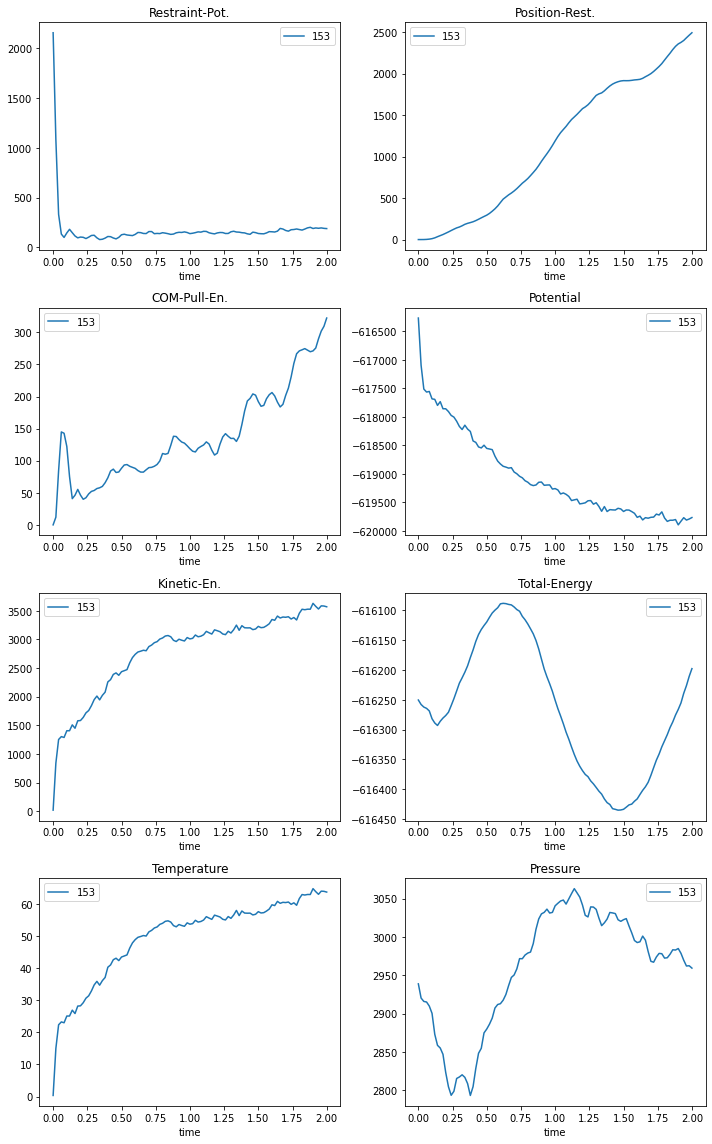

In [316]:
cols = 2
y_quantities = [
    'Restraint-Pot.',
    'Position-Rest.',
    'COM-Pull-En.',
    'Potential',
    'Kinetic-En.',
    'Total-Energy',
    'Temperature',
    'Pressure',
    'Constr.-rmsd',
    ]
n = len(y_quantities)
rows = round(n/cols)
positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Pulling forces

In [317]:
res_df_list = []
failed_list = []

query = { 
    "metadata.project": project_id,
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
    "metadata.type": 'pullf_file',
}

fp.filepad.count_documents(query)
match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    
    tmpin = tempfile.NamedTemporaryFile(mode='w+b',suffix='.xvg', delete=False)
    
    with tmpin:
        tmpin.write(content)
        
    try:
        xvg = mda.auxiliary.XVG.XVGReader(tmpin.name)
        xvg_time = xvg.read_all_times()
        xvg_data = np.array([ f.data[1:] for f in xvg ])# .flatten() # 1st entry contains times
    except: 
        logger.warning("Failed to read data set {:d}.".format(i))
        failed_list.append(nmolecules)
    else:
        res_df_list.append(pd.DataFrame({
            'nmolecules': np.array([nmolecules]*len(xvg_time), dtype=int),
            'time': xvg_time, 
            **{i: xvg_data[:,i] for i in range(nmolecules)}
        }))
    os.unlink(tmpin.name)
    print('.',end='')
print('')
res_df = pd.concat(res_df_list)
res_df_mi = res_df.set_index(['nmolecules','time'])

.


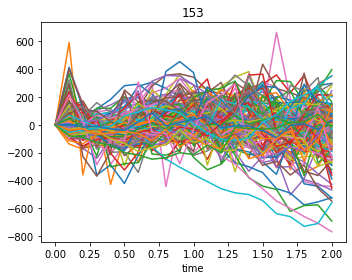

In [318]:
# pulling forces
n = len(res_df['nmolecules'].unique())
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
for pos, (key, grp) in zip(positions,res_df.groupby(['nmolecules'])):
    columns = list(set(grp.columns) - set(['nmolecules','time']))
    grp.plot('time', columns, ax=ax[pos],title=key,legend=None)
fig.tight_layout()

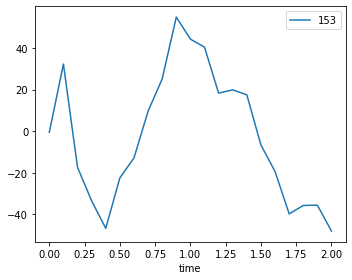

In [319]:
# mean pulling force
fig, ax = plt.subplots(1,1,figsize=(5,4))
for key, grp in res_df.groupby(['nmolecules']):
    columns = list(set(grp.columns) - set(['nmolecules','time']))
    grp = grp.set_index('time')
    grp = grp.drop(columns='nmolecules')
    grp.mean(axis=1).plot(legend=True, label=key, ax=ax)
fig.tight_layout()
#fig.legend()

### Pulling groups movement

In [320]:
res_df_list = []
failed_list = []

query = { 
    "metadata.project": project_id,
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
    "metadata.type":    'pullx_file',
}

fp.filepad.count_documents(query)
match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)


for i, c in enumerate(cursor): 
    print(c["_id"])
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])  # int(metadata["metadata"]["nmolecules"])
    
    tmpin = tempfile.NamedTemporaryFile(mode='w+b',suffix='.xvg', delete=False)
    
    with tmpin:
        tmpin.write(content)
        
    try:
        xvg = gromacs.fileformats.XVG(tmpin.name)
        xvg_time = xvg.array[0,:]
        
        #xvg_labels = ['1', '1 ref', '1 dX', '1 dY', '1 dZ', '1 g 1 X', '1 g 1 Y', '1 g 1 Z', '1 g 2 X', '1 g 2 Y', '1 g 2 Z']
        N_pull_coords = nmolecules
        N_cols = len(xvg.names)
        N_cols_per_coord = int(N_cols / N_pull_coords)
        
        xvg_labels = xvg.names[:N_cols_per_coord]
        xvg_data = {}
        for j in range(N_pull_coords):
            for k in range(N_cols_per_coord):
                xvg_data[(j,xvg_labels[k])] = xvg.array[
                    1+j*N_cols_per_coord+k,:]
        
    except: 
        logger.exception("Failed to read data set {:d}.".format(i))
        failed_list.append(nmolecules)

    else:
        res_df_list.append(pd.DataFrame({
            'nmolecules': np.array([nmolecules]*len(xvg_time), dtype=int),
            'time': xvg_time, 
            **xvg_data # {i: xvg_data[:,i] for i in range(nmolecules)}
        }))
    os.unlink(tmpin.name)
res_df = pd.concat(res_df_list)
res_df_mi = res_df.set_index(['nmolecules','time'])
res_df_mi.columns = pd.MultiIndex.from_tuples(res_df_mi.columns, names=['nmolecule', 'coord'])

{'nmolecules': 153}


In [321]:
res_df_mi

nmolecule            0                                                         \
coord                  1    1 ref     1 dX      1 dY     1 dZ 1 g 1 X 1 g 1 Y   
nmolecules time                                                                 
153        0.0   2.97331  2.97331  1.64489  0.587972 -2.40607   6.735   6.862   
           0.2   2.94656  2.95331  1.67493  0.567058 -2.35696   6.735   6.862   
           0.4   2.94938  2.93331  1.72144  0.548446 -2.33125   6.735   6.862   
           0.6   2.92238  2.91331  1.71348  0.560095 -2.30012   6.735   6.862   
           0.8   2.89462  2.89331  1.68224  0.527410 -2.29580   6.735   6.862   
           1.0   2.86233  2.87331  1.66153  0.469542 -2.28293   6.735   6.862   
           1.2   2.84866  2.85331  1.65197  0.399022 -2.28618   6.735   6.862   
           1.4   2.84189  2.83331  1.62414  0.341391 -2.30694   6.735   6.862   
           1.6   2.80705  2.81331  1.57393  0.346360 -2.29833   6.735   6.862   
           1.8   2.77322  2.79331  1.52406  0.366940 -2.28765   6.735   6.862   
           2.0   2.74352  2.77331  1.49263  0.390142 -2.26864   6.735   6.862   

nmolecule                ...      152                                   \
coord           1 g 1 Z  ...     1 dY     1 dZ 1 g 1 X 1 g 1 Y 1 g 1 Z   
nmolecules time          ...                                             
153        0.0    6.701  ...  1.16300 -2.76400   6.735   6.862   6.701   
           0.2    6.701  ...  1.15238 -2.75726   6.735   6.862   6.701   
           0.4    6.701  ...  1.12144 -2.75610   6.735   6.862   6.701   
           0.6    6.701  ...  1.10157 -2.75184   6.735   6.862   6.701   
           0.8    6.701  ...  1.07638 -2.74449   6.735   6.862   6.701   
           1.0    6.701  ...  1.06512 -2.72730   6.735   6.862   6.701   
           1.2    6.701  ...  1.07229 -2.70378   6.735   6.862   6.701   
           1.4    6.701  ...  1.09143 -2.65583   6.735   6.862   6.701   
           1.6    6.701  ...  1.07480 -2.64081   6.735   6.862   6.701   
           1.8    6.701  ...  1.05148 -2.62375   6.735   6.862   6.701   
           2.0    6.701  ...  1.02987 -2.61406   6.735   6.862   6.701   

nmolecule                                   
coord            1 g 2 X  1 g 2 Y  1 g 2 Z  
nmolecules time                             
153        0.0   6.48804  8.02500  3.93700  
           0.2   6.49613  8.01438  3.94375  
           0.4   6.51726  7.98343  3.94490  
           0.6   6.54085  7.96356  3.94916  
           0.8   6.57298  7.93838  3.95651  
           1.0   6.61907  7.92711  3.97370  
           1.2   6.70706  7.93429  3.99722  
           1.4   6.70908  7.95343  4.04518  
           1.6   6.74904  7.93680  4.06019  
           1.8   6.77123  7.91348  4.07725  
           2.0   6.80607  7.89187  4.08695  

[11 rows x 1683 columns]

In [322]:
res_df = res_df_mi.groupby(axis=1,level='coord').mean().reset_index()

In [323]:
res_df

coord,nmolecules,time,1,1 dX,1 dY,1 dZ,1 g 1 X,1 g 1 Y,1 g 1 Z,1 g 2 X,1 g 2 Y,1 g 2 Z,1 ref
0,153,0.0,3.028980,0.071167,-0.101821,0.122850,6.735,6.862,6.701,6.806171,6.760175,6.823851,3.028925
1,153,0.2,3.010662,0.067415,-0.101778,0.123251,6.735,6.862,6.701,6.802419,6.760218,6.824252,3.008925
2,153,0.4,2.993593,0.065976,-0.101798,0.125349,6.735,6.862,6.701,6.800981,6.760199,6.826350,2.988925
3,153,0.6,2.970213,0.067544,-0.098574,0.128025,6.735,6.862,6.701,6.802549,6.763423,6.829026,2.968925
4,153,0.8,2.946417,0.071891,-0.097950,0.128166,6.735,6.862,6.701,6.806896,6.764047,6.829167,2.948925
5,153,1.0,2.924505,0.076266,-0.096460,0.130276,6.735,6.862,6.701,6.811270,6.765537,6.831277,2.928925
6,153,1.2,2.907099,0.081724,-0.094818,0.131600,6.735,6.862,6.701,6.816729,6.767179,6.832601,2.908925
7,153,1.4,2.887181,0.088027,-0.097080,0.128208,6.735,6.862,6.701,6.823032,6.764917,6.829209,2.888925
8,153,1.6,2.870863,0.095166,-0.097690,0.129527,6.735,6.862,6.701,6.830170,6.764307,6.830528,2.868925
9,153,1.8,2.852494,0.101630,-0.096668,0.126841,6.735,6.862,6.701,6.836634,6.765329,6.827842,2.848925


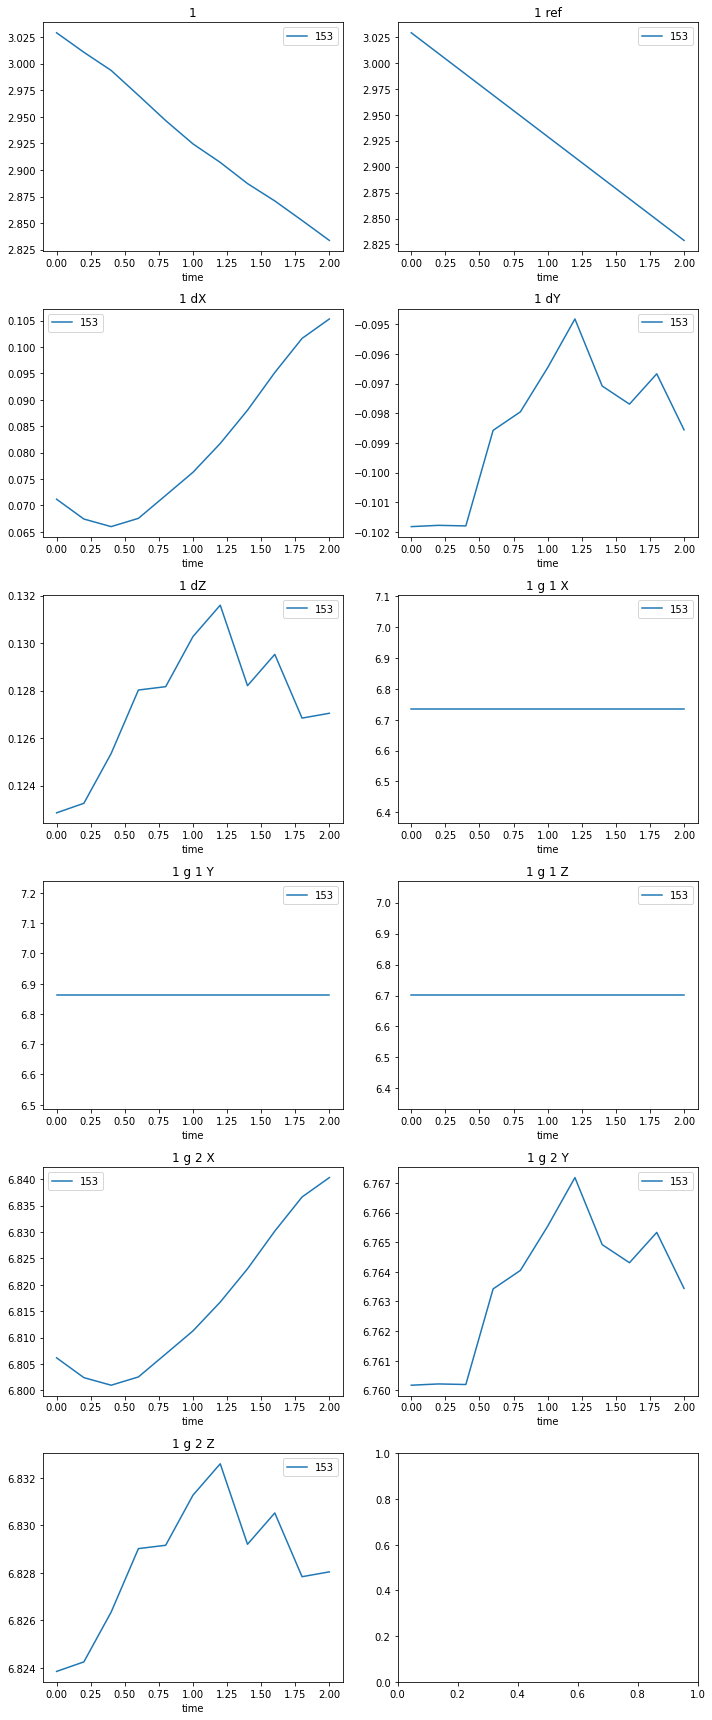

In [324]:
cols = 2
y_quantities = [
    '1', 
    '1 ref', 
    '1 dX', 
    '1 dY', 
    '1 dZ', 
    '1 g 1 X', 
    '1 g 1 Y', 
    '1 g 1 Z', 
    '1 g 2 X', 
    '1 g 2 Y', 
    '1 g 2 Z'
]
n = len(y_quantities)
rows = round(n/cols)
positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

###  Visualize trajectory

In [325]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsPull:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [326]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [327]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [328]:
res_df

,step,type,name,earliest,latest,object_count
0,GromacsPull:ProcessAnalyzeAndVisualize:push_filepad,mp4_file,NaN,2020-07-29 02:02:43.163551,2020-07-29 02:02:43.163551,1


In [329]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        obj_list.append(Video.from_file(tmp.name))
    print('.',end='')

.

In [330]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(153,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10=tmdat\x00\x00\…


### Pre-evaluated RDF

#### Overview

In [331]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

10

In [332]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [333]:
res_df

,type,earliest,latest,object_count
0,surfactant_tail_surfactant_tail_rdf,2020-07-29 02:02:43.163523,2020-07-29 02:02:43.163523,1
1,surfactant_head_surfactant_tail_rdf,2020-07-29 02:02:43.163518,2020-07-29 02:02:43.163518,1
2,surfactant_head_surfactant_head_rdf,2020-07-29 02:02:43.163512,2020-07-29 02:02:43.163512,1
3,substrate_surfactant_tail_rdf,2020-07-29 02:02:43.163507,2020-07-29 02:02:43.163507,1
4,substrate_surfactant_head_rdf,2020-07-29 02:02:43.163502,2020-07-29 02:02:43.163502,1
5,substrate_substrate_rdf,2020-07-29 02:02:43.163496,2020-07-29 02:02:43.163496,1
6,counterion_surfactant_tail_rdf,2020-07-29 02:02:43.163491,2020-07-29 02:02:43.163491,1
7,counterion_surfactant_head_rdf,2020-07-29 02:02:43.163485,2020-07-29 02:02:43.163485,1
8,counterion_substrate_rdf,2020-07-29 02:02:43.163480,2020-07-29 02:02:43.163480,1
9,counterion_counterion_rdf,2020-07-29 02:02:43.163474,2020-07-29 02:02:43.163474,1


#### Substrate - surfactant head RDF

In [465]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [466]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [467]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


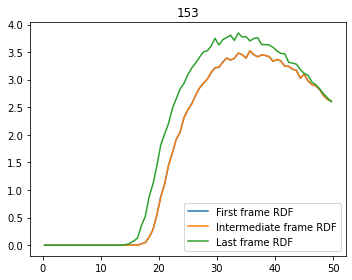

In [469]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Substrate - surfactant tail RDF

In [338]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [339]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [340]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


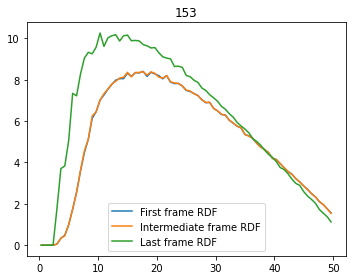

In [341]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant head - surfactant tail RDF

In [342]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [343]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [344]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


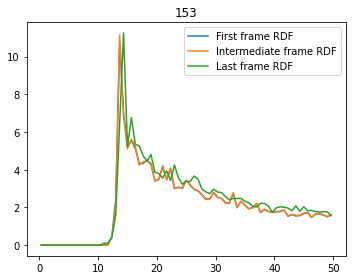

In [345]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

## Energy minimization after solvation analysis

### Overview on objects in step

In [346]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad'
}

In [347]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

20

In [348]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [349]:
res_df

,type,name,earliest,latest,object_count
0,mp4_file,NaN,2020-07-29 02:02:43.208709,2020-07-29 02:02:43.208709,1
1,surfactant_tail_rmsd,NaN,2020-07-29 02:02:43.208703,2020-07-29 02:02:43.208703,1
2,surfactant_head_rmsd,NaN,2020-07-29 02:02:43.208696,2020-07-29 02:02:43.208696,1
3,substrate_rmsd,NaN,2020-07-29 02:02:43.208690,2020-07-29 02:02:43.208690,1
4,counterion_rmsd,NaN,2020-07-29 02:02:43.208684,2020-07-29 02:02:43.208684,1
5,surfactant_tail_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.208678,2020-07-29 02:02:43.208678,1
6,surfactant_head_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.208672,2020-07-29 02:02:43.208672,1
7,surfactant_head_surfactant_head_rdf,NaN,2020-07-29 02:02:43.208666,2020-07-29 02:02:43.208666,1
8,substrate_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.208661,2020-07-29 02:02:43.208661,1
9,substrate_surfactant_head_rdf,NaN,2020-07-29 02:02:43.208655,2020-07-29 02:02:43.208655,1


### Global observables

In [350]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',  #{'$regex': 'GromacsEnergyMinimization'}
    "metadata.type": 'energy_file',
}
fp.filepad.count_documents(query)

1

In [351]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [352]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [353]:
res_mi_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        em_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),em_df.index],
            names=[*c["_id"].keys(),'step'])
        em_mi_df = em_df.set_index(mi)        
        res_mi_list.append(em_mi_df)
    print('.',end='')
print('')

res_mi_df = pd.concat(res_mi_list)
res_df = res_mi_df.reset_index()

.


In [354]:
res_mi_df

Time        Bond           U-B  Proper Dih.  \
nmolecules step                                                      
153        0.0          0.0   46.000813  13688.839844  4704.500977   
           1.0          1.0   45.966911  13688.921875  4704.511719   
           2.0          2.0   45.955669  13689.020508  4704.524414   
           3.0          3.0   45.985062  13689.149414  4704.541016   
           4.0          4.0   46.083328  13689.303711  4704.561523   
...                     ...         ...           ...          ...   
           9995.0    9995.0  194.485626  11775.187500  4290.306152   
           9996.0    9996.0  200.155518  11782.256836  4290.308105   
           9997.0    9997.0  198.480881  11774.669922  4290.308105   
           9999.0    9999.0  192.015518  11777.880859  4290.308105   
           10000.0  10000.0  202.696381  11774.557617  4290.312500   

                          LJ-14    Coulomb-14        LJ (SR)  Coulomb (SR)  \
nmolecules step                                                              
153        0.0      1018.916077  39321.550781  709907.750000   -3735228.00   
           1.0      1019.062500  39321.898438  707253.937500   -3735256.00   
           2.0      1019.241455  39322.316406  704081.187500   -3735290.25   
           3.0      1019.457336  39322.820312  700292.250000   -3735332.00   
           4.0      1019.721008  39323.441406  695768.437500   -3735384.00   
...                         ...           ...            ...           ...   
           9995.0    981.667419  39618.164062 -100496.578125   -4567889.00   
           9996.0    980.261780  39617.183594 -100496.406250   -4567898.50   
           9997.0    981.985535  39618.363281 -100494.171875   -4567897.00   
           9999.0    980.908203  39617.648438 -100494.343750   -4567903.00   
           10000.0   982.184937  39618.531250 -100488.265625   -4567920.00   

                    ...    Pres-YX     Pres-YY    Pres-YZ    Pres-ZX  \
nmolecules step     ...                                                
153        0.0      ...  44.238014 -280.455811 -24.420769  64.091400   
           1.0      ...  44.005489 -280.534760 -24.535624  63.804436   
           2.0      ...  43.726685 -280.627228 -24.666616  63.462479   
           3.0      ...  43.393604 -280.735321 -24.816006  63.058018   
           4.0      ...  42.995773 -280.861298 -24.982151  62.579689   
...                 ...        ...         ...        ...        ...   
           9995.0   ...   1.064740 -400.182129  -8.476584  14.967935   
           9996.0   ...   1.064716 -400.182861  -8.476311  14.968136   
           9997.0   ...   1.064867 -400.183380  -8.476221  14.968294   
           9999.0   ...   1.064871 -400.183624  -8.475971  14.968438   
           10000.0  ...   1.065174 -400.186646  -8.474875  14.969349   

                      Pres-ZY     Pres-ZZ  #Surf*SurfTen  T-rest  
nmolecules step                                                   
153        0.0     -24.420769 -270.158203            0.0     0.0  
           1.0     -24.535625 -270.490753            0.0     0.0  
           2.0     -24.666609 -270.885284            0.0     0.0  
           3.0     -24.816004 -271.350769            0.0     0.0  
           4.0     -24.982149 -271.897797            0.0     0.0  
...                       ...         ...            ...     ...  
           9995.0   -8.476585 -395.766632           -0.0     0.0  
           9996.0   -8.476305 -395.767181           -0.0     0.0  
           9997.0   -8.476222 -395.768250           -0.0     0.0  
           9999.0   -8.475967 -395.768707           -0.0     0.0  
           10000.0  -8.474872 -395.772003           -0.0     0.0  

[7923 rows x 33 columns]

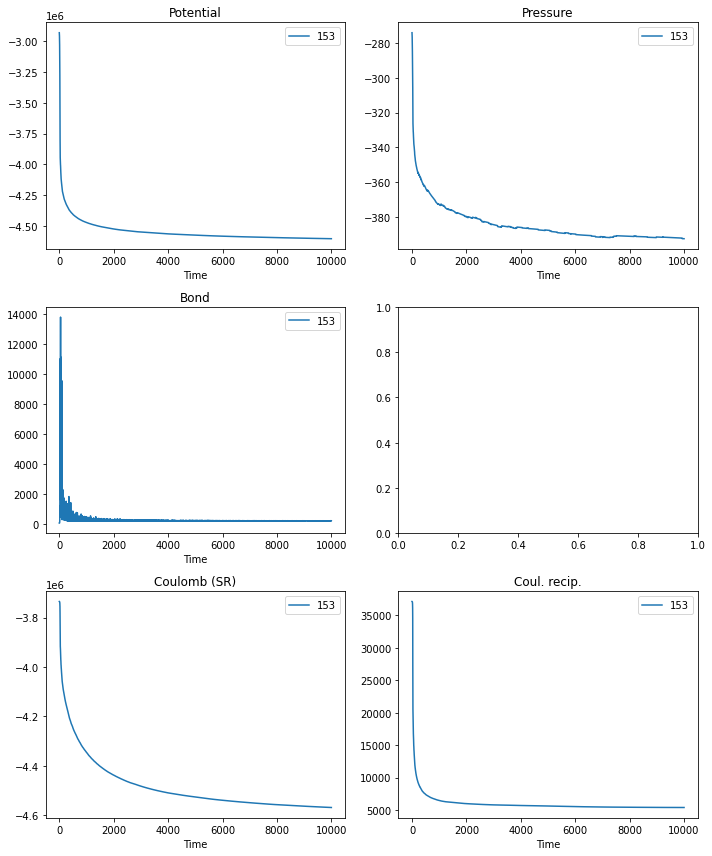

In [355]:
y_quantities = [
    'Potential',
    'Pressure',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

positions = [
    (0,0),
    (0,1),
    (1,0),
    (2,0),
    (2,1),
]
fig, ax = plt.subplots(3,2,figsize=(10,12))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

###  Visualize trajectory

In [356]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [357]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [358]:
# check

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'nmolecules': '$metadata.system.surfactant.nmolecules'
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

# for i, c in enumerate(cursor): 
#    content, metadata = fp.get_file_by_id(c["latest"])
#    nmolecules = int(c["_id"]["nmolecules"])
    

res = [ {**c['_id'], **c} for c in cursor]
columns = ['nmolecules', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [359]:
res_df

,nmolecules,name,earliest,latest,object_count
0,153,NaN,2020-07-29 02:02:43.208709,2020-07-29 02:02:43.208709,1


In [360]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        obj_dict.update({metadata['metadata']['system']['surfactant']['nmolecules']: Video.from_file(tmp.name)})
    print('.',end='')

.

In [361]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

153


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xd1Pmdat\x00\x…

## NVT equilibration analysis

### Overview on objects in step

In [362]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad'
}

In [363]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

21

In [364]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [365]:
res_df

,type,name,earliest,latest,object_count
0,mp4_file,NaN,2020-07-29 02:02:43.278176,2020-07-29 02:02:43.278176,1
1,surfactant_tail_rmsd,NaN,2020-07-29 02:02:43.278170,2020-07-29 02:02:43.278170,1
2,surfactant_head_rmsd,NaN,2020-07-29 02:02:43.278165,2020-07-29 02:02:43.278165,1
3,substrate_rmsd,NaN,2020-07-29 02:02:43.278159,2020-07-29 02:02:43.278159,1
4,counterion_rmsd,NaN,2020-07-29 02:02:43.278154,2020-07-29 02:02:43.278154,1
5,surfactant_tail_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.278148,2020-07-29 02:02:43.278148,1
6,surfactant_head_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.278143,2020-07-29 02:02:43.278143,1
7,surfactant_head_surfactant_head_rdf,NaN,2020-07-29 02:02:43.278137,2020-07-29 02:02:43.278137,1
8,substrate_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.278119,2020-07-29 02:02:43.278119,1
9,substrate_surfactant_head_rdf,NaN,2020-07-29 02:02:43.278112,2020-07-29 02:02:43.278112,1


### Global observables

In [366]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

1

In [367]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [368]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [369]:
[ c for c in cursor]

[{'_id': {'nmolecules': 153},
  'degeneracy': 1,
  'latest': '5f20cc207dc9cfbf44a4d0fc'}]

In [370]:
res_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

.


In [371]:
res_df.columns

Index(['nmolecules', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14',
       'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
       'Coul-SR:Surfactant-rest', 'LJ-SR:Surfactant-rest',
       'Coul-14:Surfactant-rest', 'LJ-14:Sur

In [372]:
res_df_mi

Time         Bond           U-B  Proper Dih.        LJ-14  \
nmolecules step                                                                
153        0.0      0.0   255.060364  11827.018555  4292.389648   982.617065   
           1.0      1.0  1910.466675  20391.828125  5287.708984  1309.395508   
           2.0      2.0  2271.792969  21995.875000  5454.842285  1456.264893   
           3.0      3.0  2631.024170  23039.972656  5467.113281  1495.142578   
           4.0      4.0  2569.132324  23755.878906  5715.117188  1509.523315   
           5.0      5.0  2858.739258  23972.652344  5734.017578  1575.558105   
           6.0      6.0  3000.514404  24603.939453  5757.772949  1493.913696   
           7.0      7.0  2934.453125  24923.369141  5816.631348  1573.382690   
           8.0      8.0  2919.964111  24857.074219  5815.797852  1564.856689   
           9.0      9.0  3016.505859  24922.201172  5772.393066  1548.535034   
           10.0    10.0  2998.802490  25051.226562  5791.252441  1592.840088   
           11.0    11.0  3063.374756  25137.058594  5842.006348  1559.382202   
           12.0    12.0  2913.150146  24810.027344  5816.493652  1609.885010   
           13.0    13.0  2772.694336  25049.000000  5823.243652  1562.408569   
           14.0    14.0  2817.621826  25122.923828  5819.358398  1599.002563   
           15.0    15.0  2870.434082  25430.925781  5652.849609  1472.540527   
           16.0    16.0  2861.887451  24895.720703  5648.092773  1481.501343   
           17.0    17.0  2706.797607  24920.246094  5746.626953  1521.682861   
           18.0    18.0  2842.982178  24675.250000  5735.476562  1544.602417   
           19.0    19.0  2861.393799  24464.785156  5835.631348  1533.745850   
           20.0    20.0  2805.463623  24588.943359  5767.593262  1547.875854   
           21.0    21.0  2980.494141  24771.171875  5683.903320  1438.436157   
           22.0    22.0  2757.845703  24756.281250  5762.929199  1512.976074   
           23.0    23.0  2681.339111  24783.333984  5734.599121  1591.245483   
           24.0    24.0  2714.394287  24724.048828  5842.629883  1508.782471   
           25.0    25.0  2651.966553  24351.501953  5856.284668  1599.494629   
           26.0    26.0  2788.777832  24376.025391  5751.035156  1532.144653   
           27.0    27.0  2929.556152  24526.326172  5706.033203  1570.802002   
           28.0    28.0  2908.934082  24393.839844  5775.346680  1500.081299   
           29.0    29.0  2749.503418  24158.472656  5780.918457  1532.042725   
           30.0    30.0  2689.544678  24172.029297  5721.354004  1541.758789   
           31.0    31.0  2790.712646  24235.302734  5789.277832  1549.815308   
           32.0    32.0  2710.263428  24066.326172  5702.763184  1539.235352   
           33.0    33.0  2820.908936  24200.001953  5779.280762  1485.875122   
           34.0    34.0  2731.485107  24283.470703  5601.617188  1516.983032   
           35.0    35.0  2629.388428  24242.634766  5796.078613  1567.861694   
           36.0    36.0  2621.102783  24302.001953  5768.996582  1504.703491   
           37.0    37.0  2613.025391  24181.396484  5754.083984  1537.193848   
           38.0    38.0  2739.845459  24224.742188  5773.209473  1488.778076   
           39.0    39.0  2681.444336  24495.835938  5834.083008  1426.133301   
           40.0    40.0  2738.279785  24067.492188  5861.443359  1498.040405   
           41.0    41.0  2702.115234  24139.646484  5786.812012  1524.551758   
           42.0    42.0  2691.239502  24203.011719  5760.313965  1541.139160   
           43.0    43.0  2861.685059  24262.095703  5772.652344  1505.494873   
           44.0    44.0  2725.108398  24053.580078  5687.039062  1565.358276   
           45.0    45.0  2807.014648  24253.669922  5610.770020  1476.829712   
           46.0    46.0  2712.527588  24154.494141  5749.788574  1567.079956   
           47.0    47.0  2702.675049  24062.134766  5810.847656  1583.783203   
           48.0    

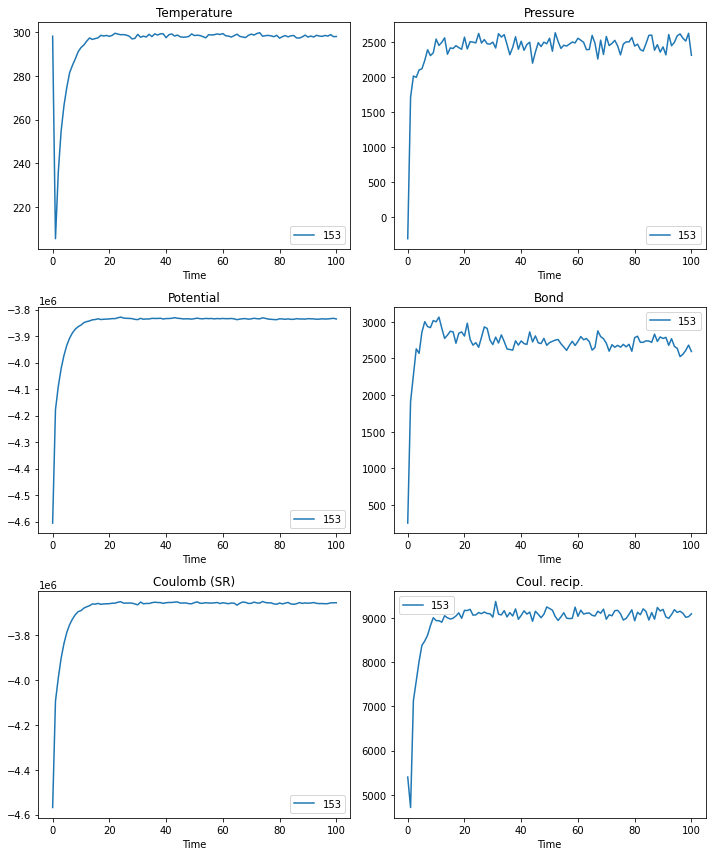

In [373]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [374]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [375]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [376]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

.

In [377]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(153,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x17B_mdat\x00\x00\…

## NPT equilibration analysis

### Datasets in step

In [378]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad'
}

In [379]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'dataset': '$metadata.step_specific.dtool_push.remote_dataset',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id']['dataset'], **c} for c in cursor]
columns = ['uuid', 'name', 'uri', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [380]:
res_df

,uuid,name,uri,earliest,latest,object_count
0,09a5e9f0-cb14-475a-982a-325fffd2dc98,2020-07-29-02-02-43-295400-n-153-m-153-gromacsnptequilibration,file://juwels01.ib.juwels.fzj.de/p/project/chfr13/hoermann4/dtool/DATASETS/2020-07-29-02-02-43-295400-n-153-m-153-gromacsnptequilibration,2020-07-29 02:02:43.330022,2020-07-29 02:02:43.330143,21


### Overview on objects in step

In [381]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad'
}

In [382]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

21

In [383]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [384]:
res_df

,type,name,earliest,latest,object_count
0,mp4_file,NaN,2020-07-29 02:02:43.330143,2020-07-29 02:02:43.330143,1
1,surfactant_tail_rmsd,NaN,2020-07-29 02:02:43.330137,2020-07-29 02:02:43.330137,1
2,surfactant_head_rmsd,NaN,2020-07-29 02:02:43.330131,2020-07-29 02:02:43.330131,1
3,substrate_rmsd,NaN,2020-07-29 02:02:43.330125,2020-07-29 02:02:43.330125,1
4,counterion_rmsd,NaN,2020-07-29 02:02:43.330119,2020-07-29 02:02:43.330119,1
5,surfactant_tail_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.330112,2020-07-29 02:02:43.330112,1
6,surfactant_head_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.330107,2020-07-29 02:02:43.330107,1
7,surfactant_head_surfactant_head_rdf,NaN,2020-07-29 02:02:43.330100,2020-07-29 02:02:43.330100,1
8,substrate_surfactant_tail_rdf,NaN,2020-07-29 02:02:43.330095,2020-07-29 02:02:43.330095,1
9,substrate_surfactant_head_rdf,NaN,2020-07-29 02:02:43.330089,2020-07-29 02:02:43.330089,1


### Global observables

In [385]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

1

In [386]:
metadata = fp.filepad.find_one(query)

In [387]:
metadata

{'_id': ObjectId('5f20d1837dc9cfbf44a4ee42'),
 'identifier': '/p/scratch/chfr13/hoermann/fireworks/launchpad/launcher_2020-07-29-01-31-45-740194/default.edr',
 'original_file_name': 'default.edr',
 'original_file_path': '/p/scratch/chfr13/hoermann/fireworks/launchpad/launcher_2020-07-29-01-31-45-740194/default.edr',
 'metadata': {'project': '2020-07-29-sds-on-au-111-indenter-passivation-trial',
  'datetime': '2020-07-29 02:02:43.330033',
  'step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
  'description': 'Parametric trial runs for SDS on Au(111) indenter passivation',
  'owners': [{'name': 'Johannes Laurin Hörmann',
    'email': 'johannes.hoermann@imtek.uni-freiburg.de',
    'username': 'fr_jh1130',
    'orcid': '0000-0001-5867-695X'}],
  'machine': 'juwels_devel',
  'parameter_label_key_dict': {'n': 'system->surfactant->nmolecules',
   'm': 'system->counterion->nmolecules'},
  'parameter_values': [{'n': 153, 'm': 153}],
  'mode': 'trial',
  'system': {'counte

In [388]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [389]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [390]:
[ c for c in cursor]

[{'_id': {'nmolecules': 153},
  'degeneracy': 1,
  'latest': '5f20d1837dc9cfbf44a4ee40'}]

In [391]:
res_list = []

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

.


In [392]:
res_df.columns

Index(['nmolecules', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14',
       'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Box-X',
       'Box-Y', 'Box-Z', 'Volume', 'Density', 'pV', 'Enthalpy', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
       'Coul-SR:Surfactant-res

In [393]:
res_df_mi

Time         Bond           U-B  Proper Dih.        LJ-14  \
nmolecules step                                                                
153        0.0      0.0  2640.053467  23778.861328  5717.828613  1467.145630   
           1.0      1.0  2654.245605  23526.535156  5687.105469  1561.011475   
           2.0      2.0  2619.712646  23554.591797  5760.872559  1557.063110   
           3.0      3.0  2559.349365  23707.310547  5671.623535  1530.281372   
           4.0      4.0  2569.499512  23648.539062  5624.923340  1535.242920   
           5.0      5.0  2675.751465  23812.183594  5583.539551  1504.701782   
           6.0      6.0  2650.552490  23668.386719  5564.568359  1518.869507   
           7.0      7.0  2614.393799  23421.337891  5643.938965  1458.303833   
           8.0      8.0  2702.918945  23660.937500  5637.316895  1443.794556   
           9.0      9.0  2583.092773  23327.414062  5536.103516  1564.317871   
           10.0    10.0  2504.213867  23341.273438  5605.983887  1528.333862   
           11.0    11.0  2558.967773  23463.021484  5557.434570  1484.840454   
           12.0    12.0  2563.932861  23358.150391  5635.250488  1584.970703   
           13.0    13.0  2533.213623  23302.089844  5649.681152  1407.501465   
           14.0    14.0  2620.971924  23159.839844  5525.600586  1472.257935   
           15.0    15.0  2626.308838  23475.605469  5622.692871  1486.489258   
           16.0    16.0  2443.249023  23267.892578  5402.404297  1459.560791   
           17.0    17.0  2589.975830  23314.972656  5571.203613  1447.131958   
           18.0    18.0  2590.618896  23314.427734  5557.267578  1483.786499   
           19.0    19.0  2519.047852  22825.158203  5521.956055  1552.556030   
           20.0    20.0  2601.010986  23015.695312  5522.890137  1468.313110   
           21.0    21.0  2592.862061  23022.605469  5525.669434  1562.186768   
           22.0    22.0  2518.933350  23264.082031  5470.102539  1517.291016   
           23.0    23.0  2384.929932  23332.376953  5506.009277  1522.898193   
           24.0    24.0  2438.505371  23120.607422  5557.521973  1553.465576   
           25.0    25.0  2440.035400  22894.105469  5432.401367  1528.621826   
           26.0    26.0  2554.855225  23083.236328  5532.353027  1537.317993   
           27.0    27.0  2507.323242  23020.136719  5457.331055  1465.570923   
           28.0    28.0  2465.066895  22703.984375  5518.666992  1523.243042   
           29.0    29.0  2519.481445  22895.134766  5572.445801  1563.492310   
           30.0    30.0  2468.466064  22855.275391  5633.643066  1595.966187   
           31.0    31.0  2396.616943  23037.568359  5586.556152  1511.805054   
           32.0    32.0  2542.511719  22898.097656  5606.522949  1540.557129   
           33.0    33.0  2553.347168  23207.689453  5535.061035  1411.148926   
           34.0    34.0  2512.553711  22970.707031  5602.714844  1572.689697   
           35.0    35.0  2599.031982  22885.855469  5564.097656  1578.687744   
           36.0    36.0  2565.585938  22824.697266  5581.482422  1517.243530   
           37.0    37.0  2488.744141  22990.994141  5498.429199  1452.813232   
           38.0    38.0  2463.508057  22744.687500  5485.296875  1439.226807   
           39.0    39.0  2438.929199  22780.796875  5581.354980  1491.765869   
           40.0    40.0  2508.778564  23014.781250  5562.530273  1470.748291   
           41.0    41.0  2482.846680  22757.837891  5512.718262  1528.463501   
           42.0    42.0  2432.045654  22876.789062  5483.690918  1407.860840   
           43.0    43.0  2549.029053  22587.511719  5485.361816  1481.130371   
           44.0    44.0  2351.004639  22778.027344  5534.890625  1546.532593   
           45.0    45.0  2490.270508  22587.632812  5495.414062  1497.636719   
           46.0    46.0  2426.044189  22935.416016  5552.289551  1481.025269   
           47.0    47.0  2479.501465  22779.195312  5485.659668  1484.539917   
           48.0    

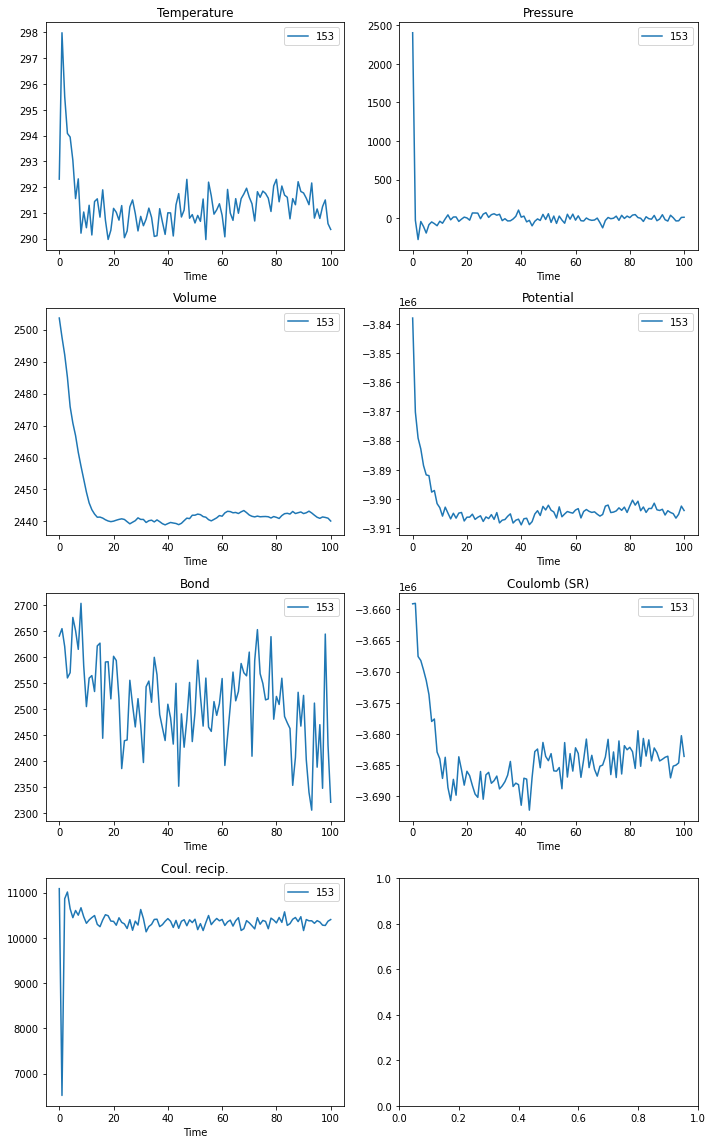

In [394]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Volume',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [395]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [396]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [397]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

.

In [398]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(153,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x16\xff\xf9mdat\x0…


### Pre-evaluated RDF

#### Overview

In [399]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

10

In [400]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [401]:
res_df

,type,earliest,latest,object_count
0,surfactant_tail_surfactant_tail_rdf,2020-07-29 02:02:43.330112,2020-07-29 02:02:43.330112,1
1,surfactant_head_surfactant_tail_rdf,2020-07-29 02:02:43.330107,2020-07-29 02:02:43.330107,1
2,surfactant_head_surfactant_head_rdf,2020-07-29 02:02:43.330100,2020-07-29 02:02:43.330100,1
3,substrate_surfactant_tail_rdf,2020-07-29 02:02:43.330095,2020-07-29 02:02:43.330095,1
4,substrate_surfactant_head_rdf,2020-07-29 02:02:43.330089,2020-07-29 02:02:43.330089,1
5,substrate_substrate_rdf,2020-07-29 02:02:43.330084,2020-07-29 02:02:43.330084,1
6,counterion_surfactant_tail_rdf,2020-07-29 02:02:43.330078,2020-07-29 02:02:43.330078,1
7,counterion_surfactant_head_rdf,2020-07-29 02:02:43.330072,2020-07-29 02:02:43.330072,1
8,counterion_substrate_rdf,2020-07-29 02:02:43.330067,2020-07-29 02:02:43.330067,1
9,counterion_counterion_rdf,2020-07-29 02:02:43.330062,2020-07-29 02:02:43.330062,1


#### Substrate - surfactant head RDF

In [402]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [403]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [404]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


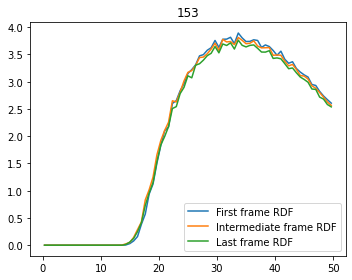

In [405]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Substrate - surfactant tail RDF

In [406]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [407]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [408]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


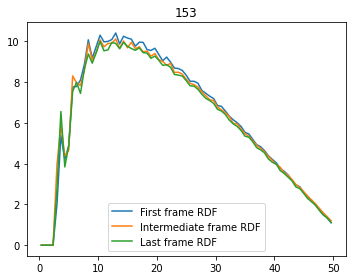

In [409]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant head - surfactant tail RDF

In [410]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [411]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [412]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


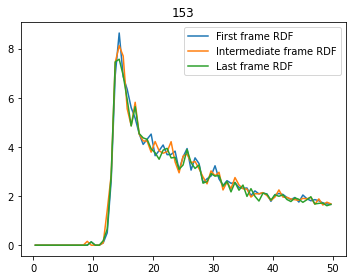

In [413]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Substrate - substrate RDF

In [414]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [415]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_substrate_rdf',
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [416]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


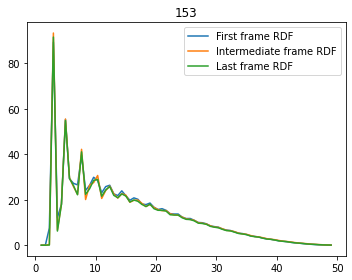

In [417]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
cutoff_index_inner = 1
cutoff_index_outer = -1
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][0][cutoff_index_inner:cutoff_index_outer], label='First frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][len(data)//2][cutoff_index_inner:cutoff_index_outer],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][-1][cutoff_index_inner:cutoff_index_outer],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

## Relaxation analysis

### Datasets in step

In [418]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad'
}

In [419]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'dataset': '$metadata.step_specific.dtool_push.remote_dataset',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id']['dataset'], **c} for c in cursor]
columns = ['uuid', 'name', 'uri', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [420]:
res_df

,uuid,name,uri,earliest,latest,object_count


### Overview on objects in step

In [421]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

0

In [422]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [423]:
res_df

,type,name,earliest,latest,object_count


### Global observables

In [424]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

0

In [425]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [426]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [427]:
[ c for c in cursor]

[]

In [428]:
res_list = []

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

ValueError: No objects to concatenate

In [ ]:
res_df.columns

In [ ]:
res_df_mi

In [ ]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Volume',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [429]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [430]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

0

In [431]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

In [432]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)


### Pre-evaluated RDF

#### Overview

In [433]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [434]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [435]:
res_df

,type,earliest,latest,object_count


#### Substrate - surfactant head RDF

In [436]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [437]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [438]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [439]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Substrate - surfactant tail RDF

In [440]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [441]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [442]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [443]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Surfactant head - surfactant tail RDF

In [444]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [445]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [446]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [447]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Surfactant head - counterion RDF

In [448]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [449]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_surfactant_head_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [450]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [451]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Surfactant head - surfactant head RDF

In [452]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [453]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_head_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [454]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [455]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
cutoff_index_inner = 1
cutoff_index_outer = -1
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][cutoff_index_inner:],data['rdf'][0][cutoff_index_inner:], label='First frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:],data['rdf'][len(data)//2][cutoff_index_inner:],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:],data['rdf'][-1][cutoff_index_inner:],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Surfactant tail - surfactant tail RDF

In [456]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [457]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_tail_surfactant_tail_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [458]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [459]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
cutoff_index_inner = 1
cutoff_index_outer = -1
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][0][cutoff_index_inner:cutoff_index_outer], label='First frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][len(data)//2][cutoff_index_inner:cutoff_index_outer],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][-1][cutoff_index_inner:cutoff_index_outer],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Substrate - substrate RDF

In [460]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [461]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_substrate_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [462]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [463]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
cutoff_index_inner = 1
cutoff_index_outer = -1
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][0][cutoff_index_inner:cutoff_index_outer], label='First frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][len(data)//2][cutoff_index_inner:cutoff_index_outer],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][-1][cutoff_index_inner:cutoff_index_outer],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)